# Sentiment Analysis: Twitter

## GOALS
The goal of this project is to detect and predict hate speech in tweets. For the sake of simplicity, a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.<br>

## DATA
Given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.
The dataset contains 31962 tweets (observations) and 3 columns. The columns are tweet id, its label and the tweet. The dataset can be found here: [test tweet](https://drive.google.com/file/d/1aEqc-GvIMuK7MhSaocfVlnzt81zvoSzO/view?usp=sharing) and [train tweet](https://drive.google.com/file/d/1lau-hVQL-pB8V8Ro_5GiaoR99V1G_Trr/view?usp=sharing)

## HIGHLIGHTS:

The following will be done:

1. Prepare Data:

    * Import data
    * Explore data: Assess, clean, re-assess data, preprocess data and EDA
    * Split data:
    
2. Build Model:

    * Baseline
    * Iterate/ Train model
    * Evaluate Model

3. Communicate Result

    * Save model


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import pickle and regex for saving model
import  pickle, re

# COllections
from collections import Counter

# Import NLP package
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS


# Model selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (train_test_split, cross_validate)
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Resampling technique for imbalance dataset
from imblearn.over_sampling import RandomOverSampler,SMOTENC,SMOTE, SVMSMOTE

# Model evaluation
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report,confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score, log_loss, precision_score,
                             recall_score, auc, RocCurveDisplay, f1_score)

# For feature preprocessing, normalizing and extraction
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline


In [5]:
# Make some downloads from nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Pack

True

In [3]:
# Define relevant functions for analysis

# Define function that loads dataset into the environment
def load_data(filename: str) -> pd.DataFrame:
    data = pd.read_csv(filename)

    # Return data
    return data


# Define tokenized function
# Note that 's' stands for strings and 't' stands for text
def preprocess_text(s):
    # Remove punctuation marks from text
    no_punc = [t for t in s if t not in string.punctuation]
    # Remove numerical values from text
    no_num = "".join([i for i in no_punc if not i.isdigit()])
    # Remove stopwords. Change all string characters to lowercase
    clean_word = [w for w in no_num.split() if w.lower() not in stopwords.words("english")]

    # Returning clean data
    return clean_word


# Define function to preprocess data
def text_proc(txt):
    
    # Remove punctuation marks from text
    no_punc = [t for t in txt if t not in string.punctuation]
    # Remove digits
    no_digit = "".join([i for i in no_punc if not i.isdigit()])
    
    # Return clean words
    return no_digit


# Define function that compares predicted label and actual value
def predicted_result(y_true: np.ndarray, y_pred: np.ndarray) -> pd.DataFrame:
    """Returns new pandas dataframe containing true and predicted labels
    
    Params:
    y_true -- np.ndarray, the initial target variable
    y_pred - np.ndarray, the predicted target variable
    Return: Pandas Dataframe of the true and predicted target variables
    """
    result = pd.DataFrame()
    result["y_true"] = y_true
    result["y_pred"] = y_pred
    result["error_term"] = (y_true - y_pred)

    return result


# Define function predicting label variable
def predict_label(X, model) -> "np.ndarray":
    """Returns the predicted series label
    
    Params:
    X -- pd.DataFrame, inputs the feature variables
    model_type -- inputs the model type

    Return: The predicted label variable as pandas Series object 
    """
    y_pred = model.predict(X)
    return y_pred


# Define function for Confusion matrix
def confusion_mat(model, X, y, model_name):
    ConfusionMatrixDisplay.from_estimator(model, X, y)
    plt.title(f"Confusion Matrix: {model_name.title()}")
    # plt.savefig(f"Confusion_mat_{model_name}.jpg", bbox_inches='tight', dpi=150);

# Define function to predict probability
def proba_test_score(model, X):
    y_proba = model.predict_proba(X)[: ,1]
    return y_proba


# Define function to get the ROC curve and AUC
def get_auc_roc_curve(y, y_proba, model_name:str):
    fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_proba)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.plot(fpr, tpr, label= f'ROC curve area={round(roc_auc,2)}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (ROC) curve: {model_name.title()}')
    plt.legend(loc="lower right")
    # plt.savefig(f"auc_roc_curve_{model_name}.jpg", bbox_inches='tight', dpi=150);


# Define function that saves model as file
def save_model(model, filename: str):
    with open(filename, "wb") as file:
        pickle.dump(model, file)


# Define function to get the model metrics
def eval_metrics(y_true, y_pred, y_proba):

    acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)
    prec_score = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    entropy = log_loss(y_true=y_true, y_pred=y_proba)
    return (
        {
        "accuracy":round(acc_score, 4),
        "precision":round(prec_score, 4),
        "recall":round(recall, 4),
        "entropy":round(entropy, 4),
        "f1_score": round(f1, 4)
        }
    )
    

# Define function for model selection
def eval_best_model(model_1, model_2,model_3,model_4,model_5,model_6,
                    X_train, X_test, y_train, y_test):
    for m in [model_1, model_2,model_3,model_4,model_5,model_6]:
        train_acc = m.score(X_train, y_train)
        test_acc = m.score(X_test, y_test)
        # Print accuracy scores
        print(f"Model accuracy for:{m}")
        print(f"Training Accuracy: {round(train_acc, 4)}")
        print(f"Test Accuracy: {round(test_acc, 4)}")
        print("="*50)



# Define function to plot most frequent words on wordcloud
def plot_freq_word(data: pd.DataFrame, feature: str, title):
    # Plot the frequent word on wordcloud
    plt.figure(figsize=[10,5])
    wordcld = WordCloud().generate(str(data[feature]))
    plt.xlabel(f"{feature}")
    plt.ylabel("Frequency")
    plt.title(f"Plot of {title}")
    plt.imshow(wordcld);


# Define a function for the bag of words
def text_bow(txt):
    txt_counter = Counter(txt)
    return txt_counter  




## Prepare Data

### Import and wrangle data

In [4]:
# Import train dataset
df1 = load_data("train_tweet.csv")
df1.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
# Load test dataset
df2 = load_data("test_tweet.csv")
df2.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


**Investigate train dataset**

In [6]:
# Investigate information about the dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [7]:
# Investigate the shape of the dataset
df1.shape

(31962, 3)

In [8]:
# Investigate duplicate in the data
df1.duplicated().sum()

0

**Investigate test dataset**

In [9]:
# Check summary of dataset
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [10]:
# Check for missing values
df2.isna().sum()

id       0
tweet    0
dtype: int64

In [11]:
# Check for duplicate
df2.duplicated().sum()

0

In [12]:
df1["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

**Preprocess data:**

In [13]:
# Get the vectorizer to transform the text variable/ feature to a token of matrix using CountVectorizer
vectorizer = CountVectorizer(analyzer=preprocess_text).fit_transform(df1["tweet"])

In [14]:
# Get the vectorizer to transform the text variable/ feature to a token of matrix using TfidfVectorizer
tfidf1 = TfidfVectorizer(analyzer=text_proc).fit_transform(df1["tweet"])


In [15]:
# Get the vectorizer to transform the text variable/ feature of the test dataframe 
#to a token of matrix using CountVectorizer
vectorizer2 = CountVectorizer(analyzer=preprocess_text).fit_transform(df2["tweet"])

### Explore Data

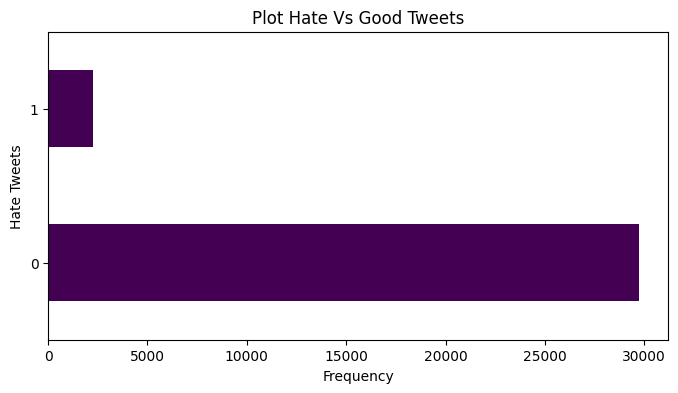

In [16]:
# Barplot
df1["label"].value_counts().plot(kind="barh", title="Plot Hate Vs Good Tweets",
                               xlabel="Frequency", ylabel="Hate Tweets",colormap='viridis',
                               figsize=(8,4));

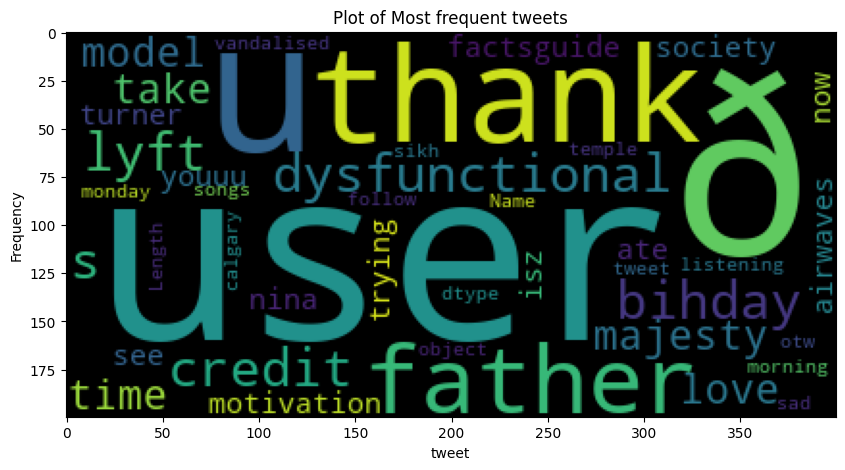

In [17]:
# Plot frequent words from tweets
plot_freq_word(data=df1, feature="tweet", title="Most frequent tweets")

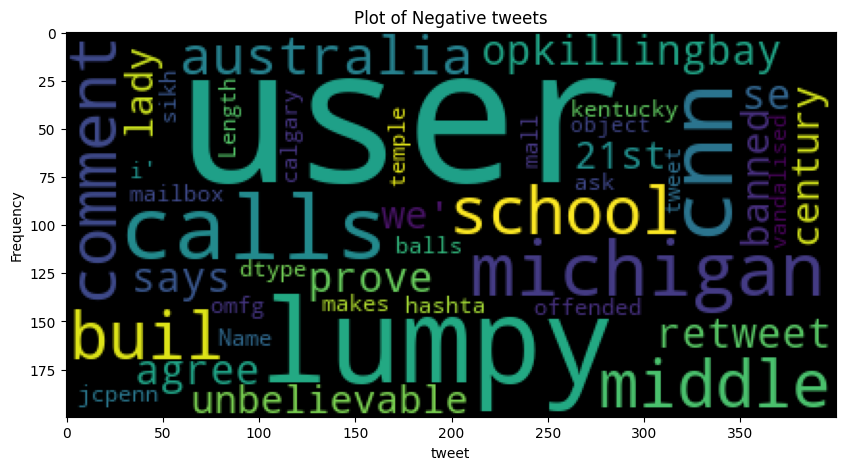

In [18]:
# Plot for hate tweet
mask = df1["label"] == 1
negative_tweet = df1[mask]
plot_freq_word(data=negative_tweet, feature="tweet", title="Negative tweets")

C:\Users\IKECHUKWU\AppData\Local\Temp\ipykernel_16388\188448957.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  postive_tweet = df2[mask2]


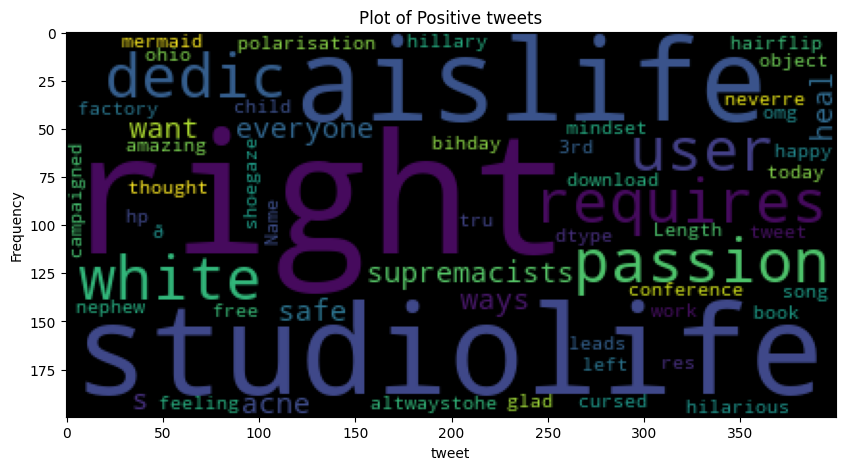

In [19]:
# Plot for hate tweet
mask2 = df1["label"] == 0
postive_tweet = df2[mask2]
plot_freq_word(data=postive_tweet, feature="tweet", title="Positive tweets")

### Split Dataset

**NB:**

The `label` variable is the `target or label variable`, while the `vectorized text` variable is the `feature variable / matrix`.

Also, since the test dataset provided from the website does not have the `label` variable, I decided to split the train dataset into train and test datasets for further analysis and to train the model. In the end, prediction was made on the test dataframe.

The dataset was resampled due to the presence of imbalance data points.

**Using `TfidfVectorizer` class**

In [20]:
# Split dataset into train and test using tfidf1
X1 = tfidf1
y1 = df1["label"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1, random_state=42, test_size=0.2)

In [21]:
# Checking the dimensions of the train and test datasets using tfidf1
print(f"Shape of X_train1 and y_train1: {X_train1.shape}, {y_train1.shape}")
print(f"Shape of X_test1 and y_test1: {X_test1.shape}, {y_test1.shape}")

Shape of X_train1 and y_train1: (25569, 120), (25569,)
Shape of X_test1 and y_test1: (6393, 120), (6393,)


**Using `CountVectorizer` class**

In [22]:
# Selecting the feature variable and the target vector or label variable
X = vectorizer
y = df1["label"]

In [23]:
# Split the feature variable and target variable into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

In [24]:
# Checking the dimensions of the train and test datasets
print(f"Shape of X_train and y_train: {X_train.shape}, {y_train.shape}")
print(f"Shape of X_test and y_test: {X_test.shape}, {y_test.shape}")

Shape of X_train and y_train: (25569, 45664), (25569,)
Shape of X_test and y_test: (6393, 45664), (6393,)


In [25]:
# Investigating dispersion/ spread of data points on the label variable
y.value_counts(normalize=True)

0    0.929854
1    0.070146
Name: label, dtype: float64

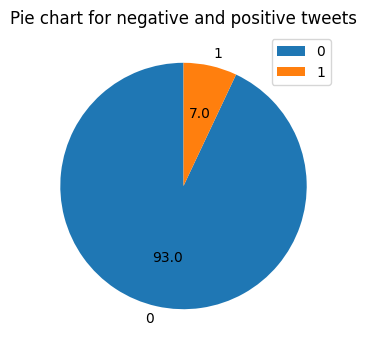

In [26]:
# Investigating dispersion of data points on the label variable: Using pie chat
plt.figure(figsize=[8,4])
count = y.value_counts()
label = y.value_counts().index

plt.pie(count, labels=label, autopct="%.1f", startangle=90)
plt.title("Pie chart for negative and positive tweets")
plt.legend(loc="upper right");

**Over sample the dataset**

In [27]:
# Instantiate and fit the oversampler class
over_sampler = RandomOverSampler(random_state=42)
X_over, y_over = over_sampler.fit_resample(X, y)

# Split the new datasets into train and test
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over,y_over,
                                                                        random_state=42, test_size=0.2)

## Model Building

In training and testing the model, I decided to use LogisticRgegreesion Model. I also tried other models to compare their level of efficiency with the LogisticRegression

### Baseline Model

In this section, I chose to build the baseline model upon which the train and evaluated models are weighed.

In [28]:
# Get the baseline accuracy using y_train
baseline_acc = y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy: {round(baseline_acc,4)}")

Baseline accuracy: 0.9301


In [29]:
# Get the baseline accuracy using oversampler
baseline_acc_over = y_train_over.value_counts(normalize=True).max()
print(f"Oversampler baseline accuracy: {round(baseline_acc_over,4)}")

Oversampler baseline accuracy: 0.5011


### Train Model


In [30]:
# Instantiate and fit the model using CountVectorizer
model_logit = LogisticRegression(random_state=42, n_jobs=-1).fit(X_train, y_train)

# Instantiate and fit the model using TfidfVectorizer
model_logit_tfid = LogisticRegression(random_state=42,n_jobs=-1).fit(X_train1, y_train1)

# Instantiate and fit the model using oversampler from CountVectorizer
model_logit_over = LogisticRegression(random_state=42,n_jobs=-1).fit(X_train_over, y_train_over)

### Evaluate Model

**NB:**

From the analysis, the `CountVectorizer` class gave a more accurate model than the `TfidfVectorizer` class, while the oversampler gave better accuracy than both. Hence, the one with the most accurate performance is used.

**Using `CountVectorizer`**

In [31]:
# Predict with the test dataset
y_test_pred = predict_label(X=X_test, model=model_logit)

In [32]:
# Compare true and predicted label variables using CountVectorizer
predicted_result(y_true=y_test, y_pred=y_test_pred)[:10]

,y_true,y_pred,error_term
12227,0,0,0
14709,0,0,0
19319,0,0,0
4308,0,0,0
24055,0,0,0
2275,0,0,0
22304,0,0,0
15297,0,0,0
21896,0,0,0
29841,0,0,0


In [33]:
# Get probability score using CountVectorizer
y_test_proba = proba_test_score(model=model_logit, X=X_test)

In [34]:
# Evaluate the model performance on test dataset
eval_metrics(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba)

{'accuracy': 0.9579,
 'precision': 0.8528,
 'recall': 0.4956,
 'entropy': 0.1197,
 'f1_score': 0.6269}

**Using `TfidfVectorizer`**

In [35]:
# Predict with the test dataset
y_test_pred_tfid = predict_label(X=X_test1, model=model_logit_tfid)

In [36]:
# Compare true and predicted label variables TfidfVectorizer
predicted_result(y_true=y_test1, y_pred=y_test_pred_tfid)[:10]

,y_true,y_pred,error_term
12227,0,0,0
14709,0,0,0
19319,0,0,0
4308,0,0,0
24055,0,0,0
2275,0,0,0
22304,0,0,0
15297,0,0,0
21896,0,0,0
29841,0,0,0


In [37]:
# Get probability score using TfidfVectorizer
y_test_proba_tfid = proba_test_score(model=model_logit_tfid, X=X_test1)

In [38]:
# Evaluate the model performance on test dataset
eval_metrics(y_true=y_test1, y_pred=y_test_pred_tfid, y_proba=y_test_proba_tfid)

{'accuracy': 0.9299,
 'precision': 0.7,
 'recall': 0.0307,
 'entropy': 0.209,
 'f1_score': 0.0588}

**Using `Oversampler`**

In [39]:
# Predict with the test dataset
y_test_pred_over = predict_label(X=X_test_over, model=model_logit_over)

In [40]:
# Compare true and predicted label variables oversampler
predicted_result(y_true=y_test_over, y_pred=y_test_pred_over)[:10]

,y_true,y_pred,error_term
20440,0,0,0
19723,0,0,0
45819,1,1,0
17432,0,0,0
13857,0,0,0
23378,0,0,0
58507,1,1,0
14183,0,0,0
22974,0,0,0
564,0,0,0


In [41]:
# Get probability score using oversampler
y_test_proba_over = proba_test_score(model=model_logit_over, X=X_test_over)

In [42]:
# Evaluate the model performance on test dataset
eval_metrics(y_true=y_test_over, y_pred=y_test_pred_over, y_proba=y_test_proba_over)

{'accuracy': 0.983,
 'precision': 0.9703,
 'recall': 0.9968,
 'entropy': 0.0834,
 'f1_score': 0.9834}

#### Compare with other models

**Using normal train and test dataset**

In [43]:
# Instantiate models
# Logit model
model_mtnb = MultinomialNB().fit(X_train, y_train)

# Decision Tree Classifier
model_dclf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# RandomForest Classifier
model_rfc = RandomForestClassifier(random_state=42, n_estimators=150,criterion="gini",
                                   max_depth=10).fit(X_train, y_train)

# KNeighborsClassifier
model_knc = KNeighborsClassifier(n_neighbors=5,weights="uniform",
                                 metric="minkowski").fit(X_train, y_train)

# SVC
model_svc = SVC(kernel="linear").fit(X_train, y_train)

In [44]:
# Evaluate performance of models
eval_best_model(model_1=model_logit, model_2=model_mtnb, 
                model_3=model_dclf, model_4=model_rfc, model_5=model_knc, 
                model_6=model_svc,X_train=X_train, X_test=X_test, 
                y_train=y_train, y_test=y_test)

Model accuracy for:LogisticRegression(n_jobs=-1, random_state=42)
Training Accuracy: 0.9855
Test Accuracy: 0.9579
Model accuracy for:MultinomialNB()
Training Accuracy: 0.9738
Test Accuracy: 0.9417
Model accuracy for:DecisionTreeClassifier(random_state=42)
Training Accuracy: 0.9998
Test Accuracy: 0.9482
Model accuracy for:RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)
Training Accuracy: 0.9301
Test Accuracy: 0.9287
Model accuracy for:KNeighborsClassifier()
Training Accuracy: 0.9476
Test Accuracy: 0.9384
Model accuracy for:SVC(kernel='linear')
Training Accuracy: 0.9971
Test Accuracy: 0.9598


**Using oversampler train and test datasets**

In [45]:
# Instantiate models
# Logit model
model_mtnb_over = MultinomialNB().fit(X_train_over, y_train_over)

# Decision Tree Classifier
model_dclf_over = DecisionTreeClassifier(random_state=42).fit(X_train_over, y_train_over)

# RandomForest Classifier
model_rfc_over = RandomForestClassifier(random_state=42, n_estimators=150,criterion="gini",
                                   max_depth=10).fit(X_train_over, y_train_over)

# KNeighborsClassifier
model_knc_over = KNeighborsClassifier(n_neighbors=5,weights="uniform",
                                 metric="minkowski").fit(X_train_over, y_train_over)

# SVC
model_svc_over = SVC(kernel="linear").fit(X_train_over, y_train_over)

In [46]:
# Evaluate performance of models
eval_best_model(model_1=model_logit_over, model_2=model_mtnb_over, 
                model_3=model_dclf_over, model_4=model_rfc_over, model_5=model_knc_over, 
                model_6=model_svc_over,X_train=X_train_over, X_test=X_test_over, 
                y_train=y_train_over, y_test=y_test_over)

Model accuracy for:LogisticRegression(n_jobs=-1, random_state=42)
Training Accuracy: 0.9946
Test Accuracy: 0.983
Model accuracy for:MultinomialNB()
Training Accuracy: 0.9705
Test Accuracy: 0.9547
Model accuracy for:DecisionTreeClassifier(random_state=42)
Training Accuracy: 0.9997
Test Accuracy: 0.966
Model accuracy for:RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)
Training Accuracy: 0.8541
Test Accuracy: 0.8477
Model accuracy for:KNeighborsClassifier()
Training Accuracy: 0.9514
Test Accuracy: 0.9233
Model accuracy for:SVC(kernel='linear')
Training Accuracy: 0.9986
Test Accuracy: 0.9857


## Communicate Result

From the comparison of models given above, the oversampler performed better and the  `SVC` model performed better than other models. I decided to investigate the confusion matrix using `SVC` model.

Hence, I used the `oversampler SVC` to build the model and saved both the `Logistic Regression` and `SVC` models were saved.

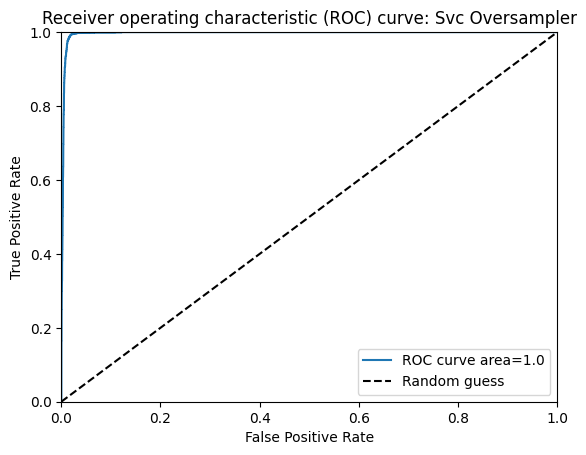

In [47]:
# Get the curve
get_auc_roc_curve(y=y_test_over, y_proba=y_test_proba_over,model_name="SVC oversampler")

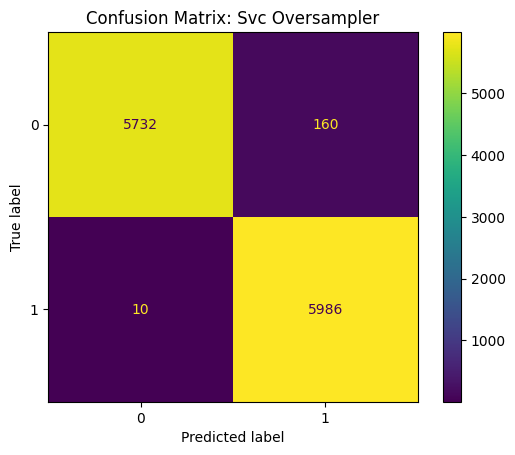

In [48]:
# Get the confusion matrix for logistic regression model
confusion_mat(model=model_svc_over, X=X_test_over, y=y_test_over, model_name="SVC oversampler")

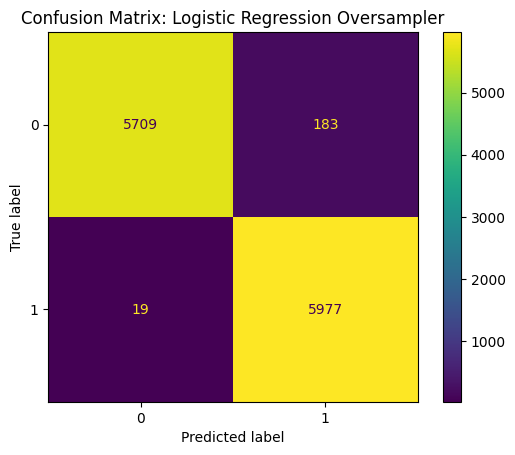

In [49]:
# Get the confusion matrix for SVC model to compare with logistic regression
confusion_mat(model=model_logit_over, X=X_test_over, y=y_test_over, model_name="Logistic Regression Oversampler")

### Predicting label variable from Test DataFrame

In [50]:
# Drop a column
df2 = df2.copy()
df2.drop(columns="id", inplace=True)
df2.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."


In [51]:
model_svc_over2 = SVC(kernel="linear", random_state=42).fit(X_over, y_over)

In [ ]:
y_pred_test = model_svc_over2.predict(vectorizer2)


In [ ]:
result = pd.DataFrame({"label":y_pred_test, "tweets":vectorizer2})
result.head()

### Save Model

In [54]:
save_model( model=model_svc_over, filename="model_svc_over_sent")
